## Импорт пакетов и сбор датасета.

1. **Страна** - (индекс).

2. **Плотность населения (P/Km²):**  
  Количество жителей на квадратный километр.

3. **Социальная поддержка:**\
Национальное среднее значение бинарных ответов на вопрос Всемирного проекта счастья (GWP): «Если у вас возникнут проблемы, есть ли у вас родственники или друзья, на которых вы можете рассчитывать, чтобы помочь вам в любой нужный момент, или нет?»

4. **Процент городского населения:**\
Доля жителей, проживающих в городе.

5. **LN ВВП на душу населения по ППС:**\
Статистика ВВП на душу населения по паритету покупательной способности с использованием постоянных цен международного доллара 2011 года.

6. **Восприятие коррупции:**  
Национальное среднее ответов на вопросы о коррупции в государственном секторе и бизнесе.

7. **Субъективное благополучие (целевая переменная):**  
Показатель счастья/субъективного благополучия по Gallup World Poll. Вопрос: «Представьте лестницу от 0 (худшая жизнь) до 10 (лучшая жизнь). На какой ступени вы сейчас?» Также известен как лестница Кантрил.

In [1]:
!pip install outlier_utils
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 9.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import pingouin as pg
from outliers import smirnov_grubbs as grubbs
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode
from scipy import stats
import seaborn as sns
from scipy.stats import pearsonr

In [3]:
!gdown 1vIzpX7YqGg9yw7NJNpfEHEoDYjLOo5zj
!gdown 17fXJy3qA8MUoDel6PG6IRLkol2_QQ46v

Downloading...
From: https://drive.google.com/uc?id=1vIzpX7YqGg9yw7NJNpfEHEoDYjLOo5zj
To: /content/population_by_country_2020.csv
100% 15.9k/15.9k [00:00<00:00, 32.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=17fXJy3qA8MUoDel6PG6IRLkol2_QQ46v
To: /content/WHR20_DataForFigure2.1.csv
100% 38.2k/38.2k [00:00<00:00, 64.9MB/s]


In [4]:
data = pd.read_csv("/content/WHR20_DataForFigure2.1.csv")
pops = pd.read_csv("/content/population_by_country_2020.csv")

In [5]:
data = data[['Country name', 'Ladder score', 'Perceptions of corruption', "Logged GDP per capita", "Social support"]]
pops = pops[['Country (or dependency)', 'Density (P/Km²)', 'Urban Pop %']]

In [6]:
data = data.rename(columns={'Country name': 'country'})
pops = pops.rename(columns={'Country (or dependency)': 'country'})
df = pd.merge(data, pops, on='country')

In [7]:
df = df.set_index('country')
df.to_excel("MSM_dataset.xlsx", index=True)
len(df)

142

In [8]:
rg_df = df.reset_index()
rg_df["Urban Pop %"] = rg_df["Urban Pop %"].str.rstrip(" %").apply(lambda x: float(x)/100 if x != "N.A." else 0)

In [9]:

df['Urban Pop %'] = (df['Urban Pop %'].str.replace(r'\s*%', '', regex=True).replace('N.A.', pd.NA))
df['Urban Pop %'] = pd.to_numeric(df['Urban Pop %'], errors='coerce')
df['Urban Pop %'] = df['Urban Pop %'].fillna(df['Urban Pop %'].median()).astype(int)

## Постановка задачи.

### 1. Описание и обоснование системы показателей:

**Целевая переменная:** Субъективное благополучие.\
Данный показатель широко используется в исследованиях счастья и отражает самооценку качества жизни. Он позволяет сравнивать субъективное восприятие благополучия в разных странах и культурах.

**Объясняющие переменные:**\
Другие показатели отражают отдельные измеримые качества страны, которые могут влиять на уровень счастья граждан.

**Обоснование репрезентативности выборки:**\
Выборка включает страны с разным уровнем экономического развития, социальной структуры и культурных особенностей, что снижает риск систематической ошибки и повышает обобщаемость выводов.\
Данные охватывают значительную часть генеральной совокупности, что обеспечивает репрезентативность и статистическую достоверность результатов.

### 2. Выдвижение рабочих гипотез исследования:

- **H0 (Нулевая гипотеза):**  
Связь между субъективным благополучием и объясняющими переменными отсутствует.

- **H1 (Альтернативная гипотеза 1):**  
Экономическое благосостояние влияет на уровень субъективного благополучия.

- **H2 (Альтернативная гипотеза 2):**  
Характеристики окружающей социальной среды, такие как плотность населения, уровень урбанизации, социальные связи и восприятие коррупции, оказывают влияние на субъективное благополучие.

## Основные характеристики зависимой переменной.

In [10]:
print("1. Характеристики положения СВ:")
print(f" Среднее: {df['Ladder score'].mean():.2f}")
print(f" Мода: {mode(df['Ladder score']):.2f}")
print(f" Медиана: {df['Ladder score'].median():.2f}")
print("\n2. Характеристики разброса СВ:")
print(f" Размах вариации: {df['Ladder score'].max() - df['Ladder score'].min():.2f}")
print(f" Стандартное отклонение: {df['Ladder score'].std():.2f}")
print(f" Дисперсия: {df['Ladder score'].var():.2f}")
print(f" Коэффициент вариации: {(df['Ladder score'].std() / df['Ladder score'].mean()) * 100:.2f}%")
print("\n3. Ранговые характеристики СВ:")
print(f" Квантили:\n{df['Ladder score'].quantile([0.25, 0.5, 0.75])}")

1. Характеристики положения СВ:
 Среднее: 5.48
 Мода: 7.81
 Медиана: 5.54

2. Характеристики разброса СВ:
 Размах вариации: 5.24
 Стандартное отклонение: 1.13
 Дисперсия: 1.28
 Коэффициент вариации: 20.65%

3. Ранговые характеристики СВ:
 Квантили:
0.25    4.7254
0.50    5.5407
0.75    6.2282
Name: Ladder score, dtype: float64


**Вывод:**\
Распределение СВ характеризуется стабильными и симметричными значениями с умеренной вариативностью. Данные не демонстрируют значительных экстремальных отклонений, что позволяет говорить о надежном и предсказуемом поведении изучаемой величины.


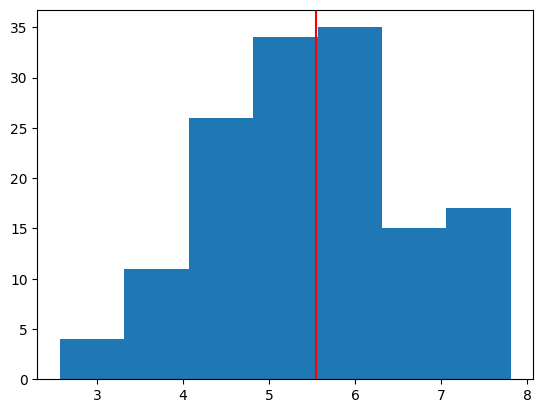

In [11]:
plt.hist(df['Ladder score'], bins=7)
plt.axvline(df['Ladder score'].median(), color='red')
plt.show()

## Диагностика выбросов.

Максимум выборки:7.81 | Минимум выборки:2.57

IQR: 1.50
Границы выбросов (3σ): 2.08 - 8.87
Границы выбросов (1.5 IQR): 2.47 - 8.48
Границы выбросов (3 IQR): 0.22 - 10.74

Выбросов по правилу 3σ, 1.5 IQR и 3 IQR нет!


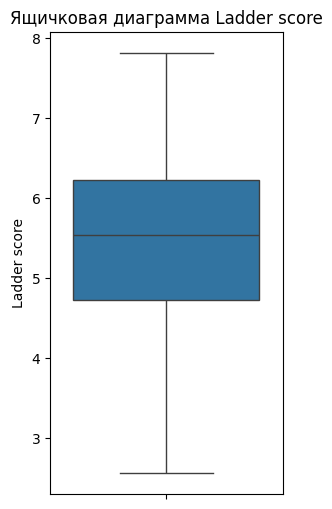

Нет выбросов: True


In [12]:
Q1, Q3 = df['Ladder score'].quantile([0.25, 0.75])
IQR = Q3 - Q1
print(f"Максимум выборки:{df['Ladder score'].max():.2f} | Минимум выборки:{df['Ladder score'].min():.2f}\n")
print(f"IQR: {IQR:.2f}")
print(f"Границы выбросов (3σ): {df['Ladder score'].mean() - 3 * df['Ladder score'].std():.2f} - {df['Ladder score'].mean() + 3 * df['Ladder score'].std():.2f}")
print(f"Границы выбросов (1.5 IQR): {Q1 - 1.5 * IQR:.2f} - {Q3 + 1.5 * IQR:.2f}")
print(f"Границы выбросов (3 IQR): {Q1 - 3 * IQR:.2f} - {Q3 + 3 * IQR:.2f}")

print(f"\nВыбросов по правилу 3σ, 1.5 IQR и 3 IQR нет!")

plt.figure(figsize=(3, 6))
sns.boxplot(y=df['Ladder score'])
plt.title("Ящичковая диаграмма Ladder score")
plt.show()

print(f"Нет выбросов: {len(grubbs.test(df['Ladder score'].values, alpha=0.05)) == len(df['Ladder score'])}")

## Проверка соответствия эмпирического распределения нормальному закону.


Переменная: Density (P/Km²)
  Коэффициент асимметрии: 9.357
  Коэффициент эксцесса: 96.897

Переменная: Social support
  Коэффициент асимметрии: -1.187
  Коэффициент эксцесса: 1.315

Переменная: Logged GDP per capita
  Коэффициент асимметрии: -0.386
  Коэффициент эксцесса: -0.844

Переменная: Perceptions of corruption
  Коэффициент асимметрии: -1.658
  Коэффициент эксцесса: 2.369

Переменная: Ladder score
  Коэффициент асимметрии: -0.124
  Коэффициент эксцесса: -0.490

Переменная: Urban Pop %
  Коэффициент асимметрии: -0.257
  Коэффициент эксцесса: -0.876



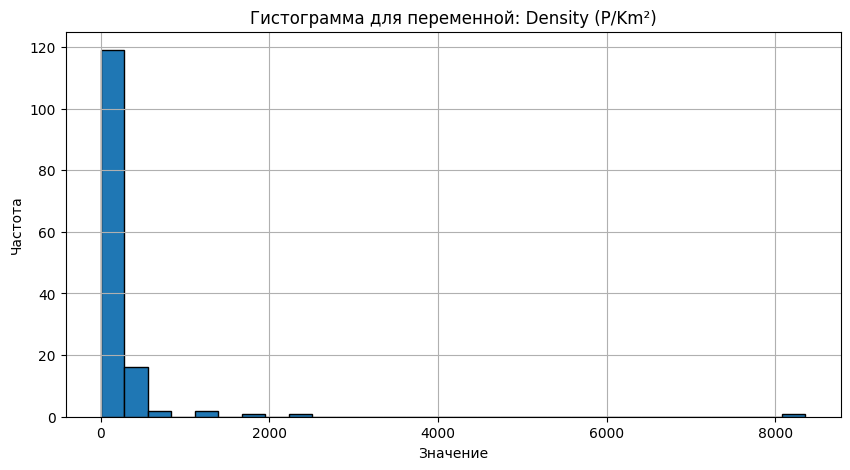

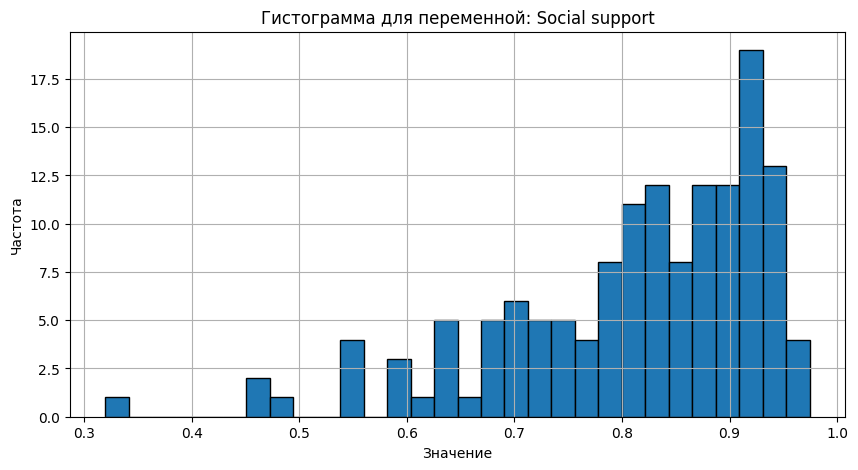

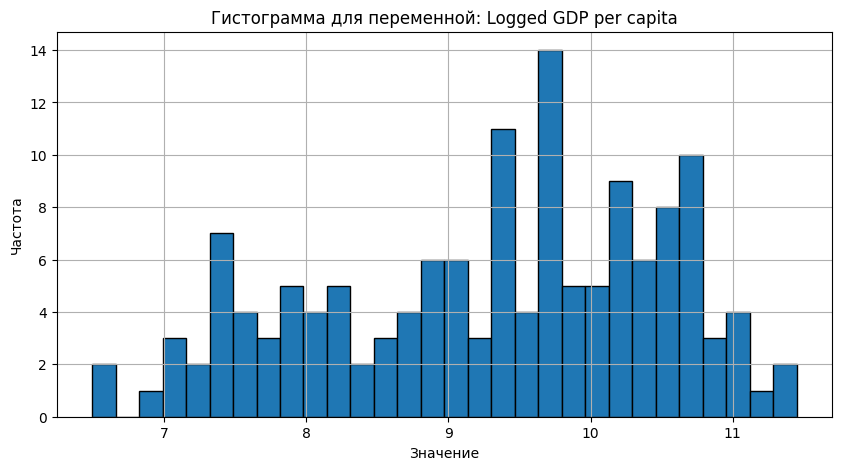

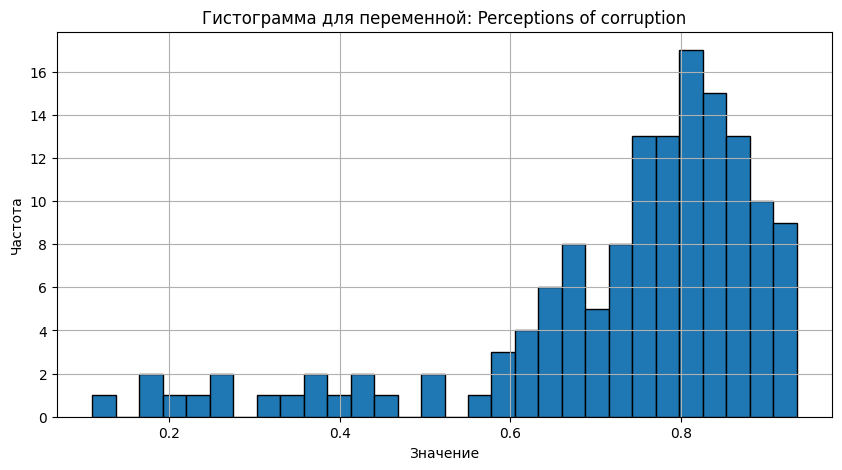

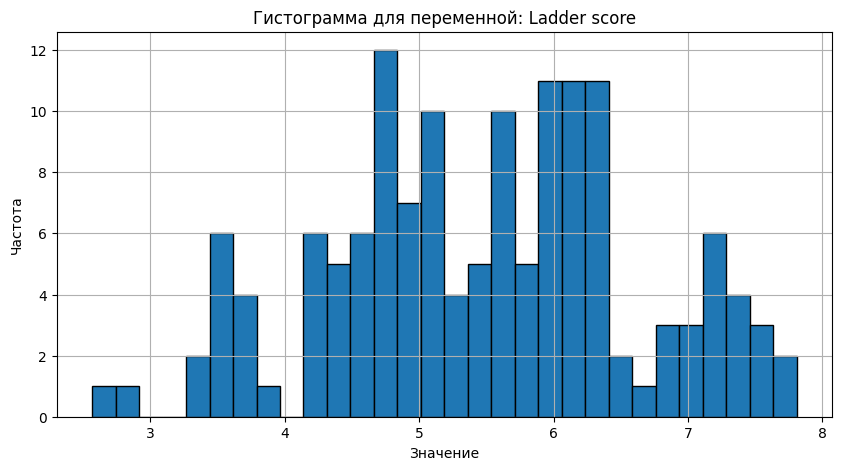

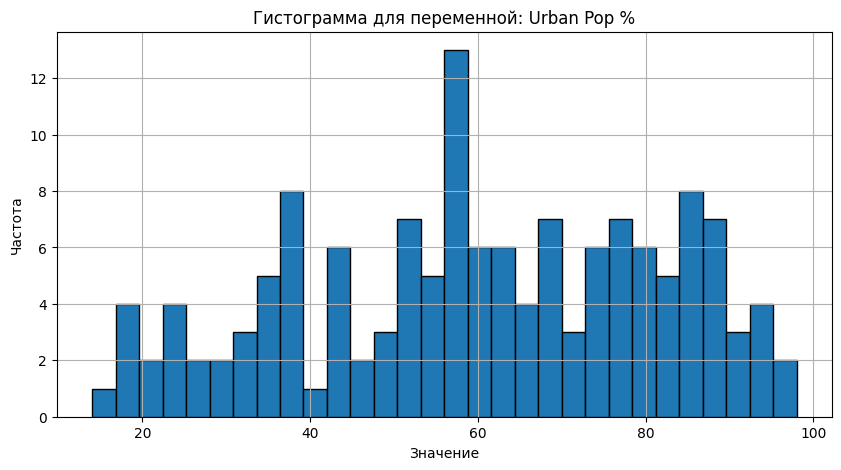

Переменная: Density (P/Km²)
  Колмогоров-Смирнов: p-value = 0.0000
  Пирсон (хи-квадрат): p-value = 0.0000
  Шапиро-Уилк: p-value = 0.0000
  Нормальность отвергается

Переменная: Social support
  Колмогоров-Смирнов: p-value = 0.0308
  Пирсон (хи-квадрат): p-value = 0.0000
  Шапиро-Уилк: p-value = 0.0000
  Нормальность отвергается

Переменная: Logged GDP per capita
  Колмогоров-Смирнов: p-value = 0.1828
  Пирсон (хи-квадрат): p-value = 0.0006
  Шапиро-Уилк: p-value = 0.0005
  Нормальность отвергается

Переменная: Perceptions of corruption
  Колмогоров-Смирнов: p-value = 0.0001
  Пирсон (хи-квадрат): p-value = 0.0000
  Шапиро-Уилк: p-value = 0.0000
  Нормальность отвергается

Переменная: Ladder score
  Колмогоров-Смирнов: p-value = 0.8321
  Пирсон (хи-квадрат): p-value = 0.3324
  Шапиро-Уилк: p-value = 0.2166
  Нормальность не отвергается

Переменная: Urban Pop %
  Колмогоров-Смирнов: p-value = 0.5137
  Пирсон (хи-квадрат): p-value = 0.0007
  Шапиро-Уилк: p-value = 0.0022
  Нормальность 

In [13]:
#1.Расчёт коэффициентов асимметрии и эксцесса
from scipy.stats import skew, kurtosis
variables = ['Density (P/Km²)','Social support','Logged GDP per capita','Perceptions of corruption','Ladder score','Urban Pop %']
for var in variables:
    data = df[var].dropna()
    skewness = skew(data)
    kurt = kurtosis(data)
    print(f"Переменная: {var}")
    print(f"  Коэффициент асимметрии: {skewness:.3f}")
    print(f"  Коэффициент эксцесса: {kurt:.3f}\n")
#2.Построение гистограммы распределения
import matplotlib.pyplot as plt
for var in variables:
    plt.figure(figsize=(10, 5))
    df[var].hist(bins=30, edgecolor='black')
    plt.title(f'Гистограмма для переменной: {var}')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.show()
#3.Проверка гипотезы о нормальном распределении совокупности с использованием статистического критерия (критерий Пирсона, Колмогорова и т.д.)
from scipy.stats import kstest, normaltest, shapiro
for var in variables:
    data = df[var].dropna()
    ks_stat, ks_p = kstest(data, 'norm', args=(data.mean(), data.std()))
    chi2_stat, chi2_p = normaltest(data)
    shapiro_stat, shapiro_p = shapiro(data)
    print(f"Переменная: {var}")
    print(f"  Колмогоров-Смирнов: p-value = {ks_p:.4f}")
    print(f"  Пирсон (хи-квадрат): p-value = {chi2_p:.4f}")
    print(f"  Шапиро-Уилк: p-value = {shapiro_p:.4f}")
    alpha = 0.05
    reject = any([p < alpha for p in [ks_p, chi2_p, shapiro_p]])
    if not reject:
        print("  Нормальность не отвергается\n")
    else:
        print("  Нормальность отвергается\n")
#4Выводы после каждого пункта


ВЫВОДЫ: 1.	Переменная: Density (P/Km²)
Коэффициент асимметрии (As = 9.357):
Положительное значение, значительно превышающее 0.5 по модулю, указывает на сильную правостороннюю асимметрию.
Коэффициент эксцесса (Ek = 96.897):
Крайне высокое положительное значение свидетельствует о резко островершинном распределении (сильное отклонение от нормального).
2.	Переменная: Social support
Коэффициент асимметрии (As = -1.187):
Отрицательное значение с модулем больше 0.5 указывает на умеренную левостороннюю асимметрию.
Коэффициент эксцесса (Ek = 1.315):
Положительное значение больше 0.5 говорит о умеренном островершинном распределении.
3.	Переменная: Logged GDP per capita
Коэффициент асимметрии (As = -0.386):
Отрицательное значение, но модуль меньше 0.5, что указывает на слабую левостороннюю асимметрию.
Коэффициент эксцесса (Ek = -0.844):
Отрицательное значение с модулем больше 0.5 свидетельствует о умеренном плосковершинном распределении.
4.	Переменная: Perceptions of corruption
Коэффициент асимметрии (As = -1.658):
Отрицательное значение с модулем больше 0.5 указывает на умеренную левостороннюю асимметрию.
Коэффициент эксцесса (Ek = 2.369):
Положительное значение больше 0.5 говорит о умеренном островершинном распределении.
5.	Переменная: Ladder score
Коэффициент асимметрии (As = -0.124):
Отрицательное значение с модулем меньше 0.5 указывает на слабую левостороннюю асимметрию.
Коэффициент эксцесса (Ek = -0.490):
Отрицательное значение с модулем меньше 0.5 свидетельствует о незначительном плосковершинном распределении.

Проверка нормальности : у всех переменных кроме Ladder score, значение p-value меньше уровня значимости в 5%, значит гипотеза о нормальном распределении отвергается. В то время как p-value Ladder Score больше уровня значимости в 5%, значит гипотеза о нормальном распределении  НЕ отвергается.




## Корреляционный анализ.

**Построение полей корреляции между показателем "Ladder score" и другими переменными:**


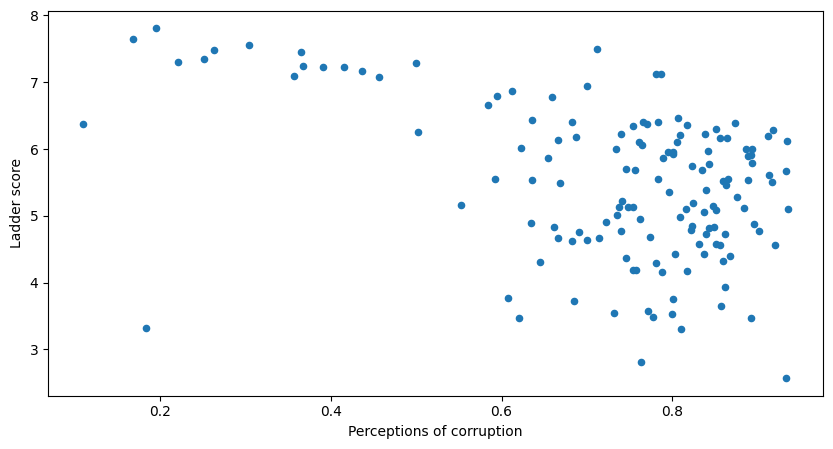

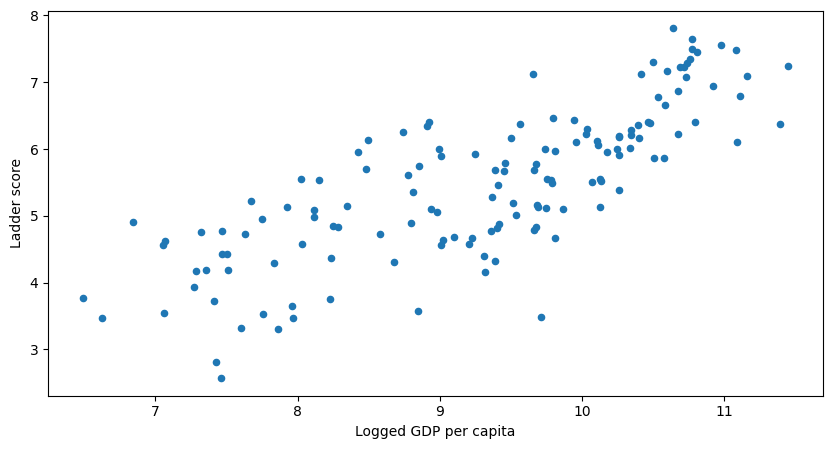

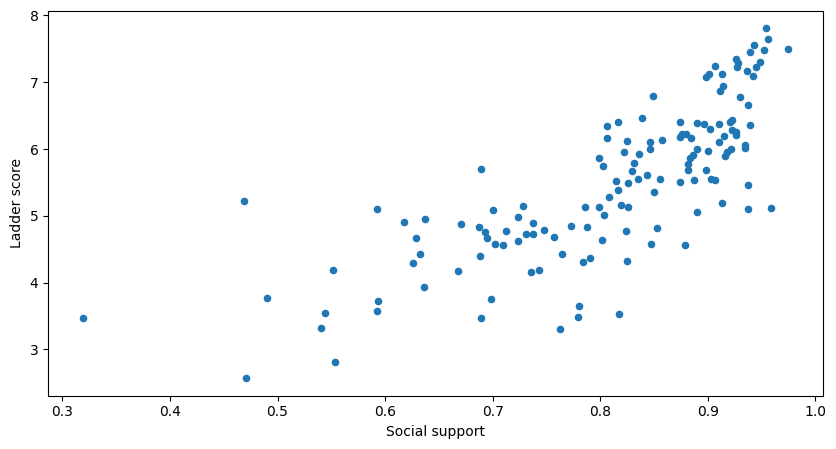

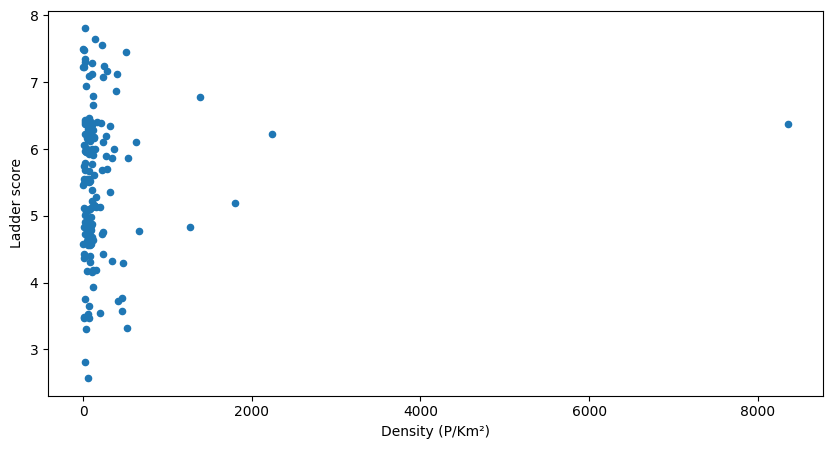

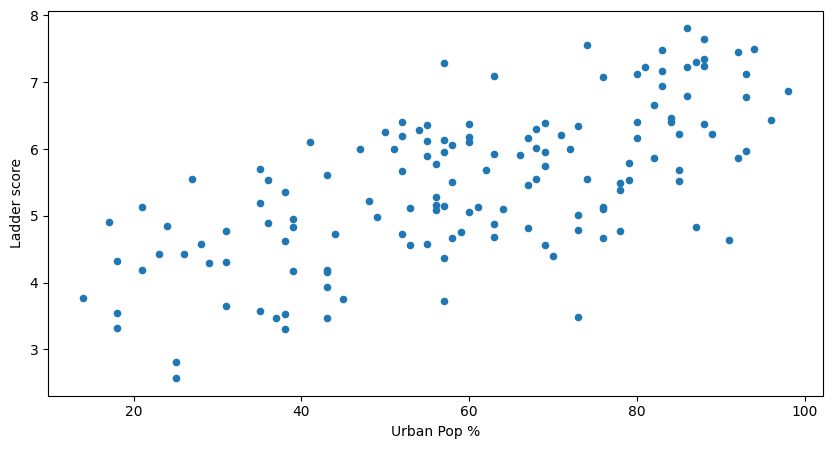

In [14]:
df.plot('Perceptions of corruption','Ladder score', kind = 'scatter', figsize = (10, 5))
df.plot('Logged GDP per capita', 'Ladder score', kind = 'scatter', figsize = (10, 5))
df.plot('Social support', 'Ladder score', kind = 'scatter', figsize = (10, 5))
df.plot('Density (P/Km²)', 'Ladder score', kind = 'scatter', figsize = (10, 5))
df.plot('Urban Pop %', 'Ladder score', kind = 'scatter', figsize = (10, 5))
plt.show()

Показатель субъективного благополучия имеет отрицательную связь с переменной, отражающей восприятие коррупции. Также положительную связь с показателями ВВП на душу населения, процентом городского населения и переменной, отражающей уровень социальной поддержки. По полю корреляции между переменными "Ladder score" и "Density (P/Km²)" нельзя сделать вывод о характере связи субъективного благополучия и плотности населения, в том числе из-за сильного влияния выбросов на график.

**Построение поля рассеяния после удаления выбросов:**


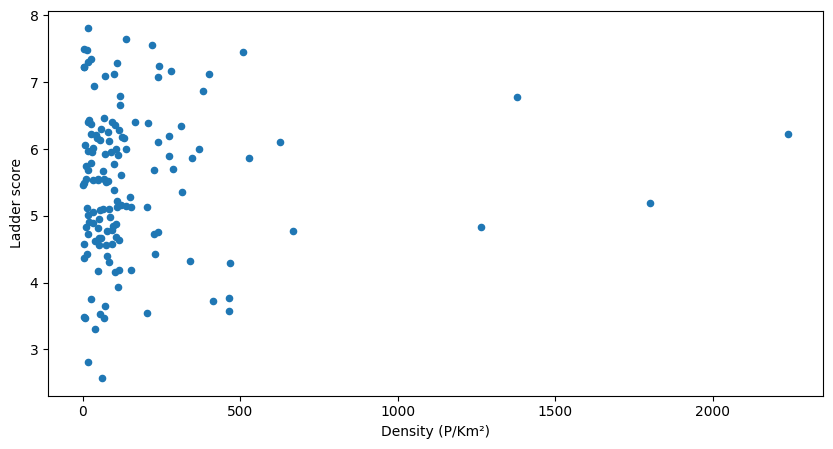

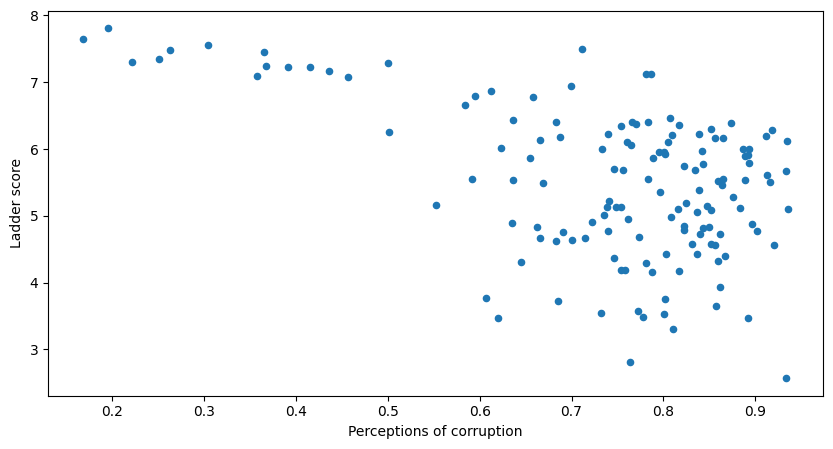

In [15]:
df_newc = df.drop(df['Density (P/Km²)'].idxmax())
df_newc2 = df_newc[df_newc['Perceptions of corruption'] != df_newc['Perceptions of corruption'].nsmallest(2).iloc[-1]]
df_newc2.plot('Density (P/Km²)', 'Ladder score', kind = 'scatter', figsize = (10, 5))
df_newc2.plot('Perceptions of corruption', 'Ladder score', kind = 'scatter', figsize = (10, 5))
plt.show()

Было удалено два выброса. Для графика корреляции плотности населения и субъективного благополучия: значения 8358; 6.38, соответственно. Для графика корреляции восприятия коррупции и субъективного благополучия: 0.18; 3.31. Удаление значения сгладило первый график.

**Матрица парных коэффициентов корреляции до удаления выбросов:**

In [17]:
df[['Ladder score', 'Perceptions of corruption', 'Logged GDP per capita', 'Social support', 'Density (P/Km²)', 'Urban Pop %']].corr(method='pearson')

,Ladder score,Perceptions of corruption,Logged GDP per capita,Social support,Density (P/Km²),Urban Pop %
Ladder score,1.000000,-0.440504,0.784148,0.771148,0.077638,0.669599
Perceptions of corruption,-0.440504,1.000000,-0.328647,-0.214829,-0.289187,-0.233118
Logged GDP per capita,0.784148,-0.328647,1.000000,0.784978,0.165023,0.763935
Social support,0.771148,-0.214829,0.784978,1.000000,0.068763,0.599933
Density (P/Km²),0.077638,-0.289187,0.165023,0.068763,1.000000,-0.003361
Urban Pop %,0.669599,-0.233118,0.763935,0.599933,-0.003361,1.000000


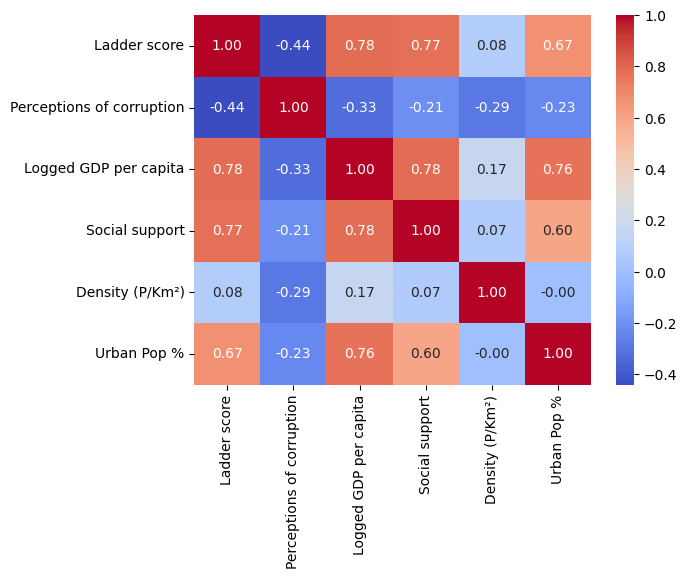

In [18]:
sns.heatmap(df[['Ladder score', 'Perceptions of corruption', 'Logged GDP per capita', 'Social support', 'Density (P/Km²)', 'Urban Pop %']].corr(method='pearson'), annot =True, fmt='.2f', cmap='coolwarm')
plt.show()

**Матрица парных коэффициентов корреляции после удаления выбросов:**

In [19]:
df_newc2[['Ladder score', 'Perceptions of corruption', 'Logged GDP per capita', 'Social support', 'Density (P/Km²)', 'Urban Pop %']].corr(method='pearson')

,Ladder score,Perceptions of corruption,Logged GDP per capita,Social support,Density (P/Km²),Urban Pop %
Ladder score,1.000000,-0.511880,0.781061,0.763237,0.057719,0.662041
Perceptions of corruption,-0.511880,1.000000,-0.350360,-0.269608,-0.021080,-0.305767
Logged GDP per capita,0.781061,-0.350360,1.000000,0.782173,0.087462,0.768744
Social support,0.763237,-0.269608,0.782173,1.000000,0.034239,0.588836
Density (P/Km²),0.057719,-0.021080,0.087462,0.034239,1.000000,0.009371
Urban Pop %,0.662041,-0.305767,0.768744,0.588836,0.009371,1.000000


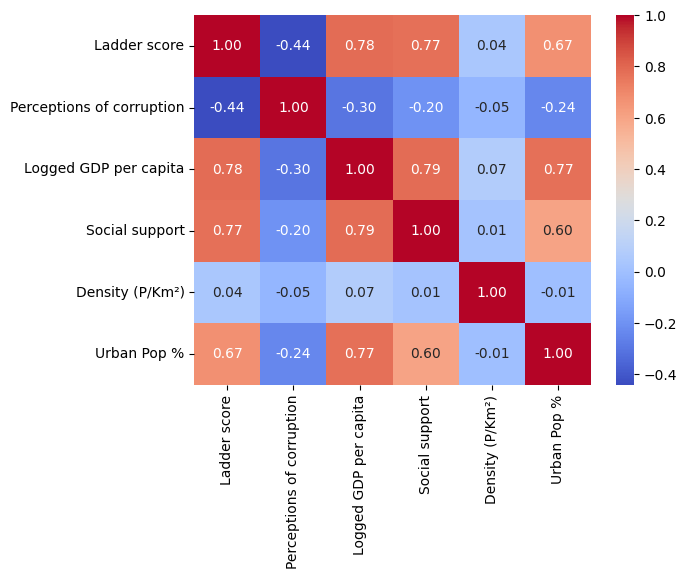

In [20]:
sns.heatmap(df_newc[['Ladder score', 'Perceptions of corruption', 'Logged GDP per capita', 'Social support', 'Density (P/Km²)', 'Urban Pop %']].corr(method='pearson'), annot =True, fmt='.2f', cmap='coolwarm')
plt.show()

Существенной разницы между матрицами до и после удаления выбросов не наблюдается. \\
Матрица парных коэффициентов корреляции указывается на умеренную обратную связь между показателем субъективного благополучия и перменной, отражающей степень восприятия коррупции. А также на сильную прямую связь целевой переменной с показателями ВВП на душу населения, процентом городского населения и переменной, отражающей уровень социальной поддержки. Значение коэффициента корреляции между показателями 'Ladder score' и 'Density (P/Km²)' очень мало, что может свидетельствовать об отсутствии связи между субъективным благополучием и плотностью населения.

**Проверка значимости коэффициентов корреляции**

Значения p-value для парных коэффициентов корреляции:

In [21]:
df_cor = pd.DataFrame({
    "Perceptions of corruption": [pearsonr(df['Ladder score'], df['Perceptions of corruption'])[1]],
    "Logged GDP per capita": [pearsonr(df['Ladder score'], df['Logged GDP per capita'])[1]],
    "Social support": [pearsonr(df['Ladder score'], df['Social support'])[1]],
    "Density (P/Km²)":[pearsonr(df['Ladder score'], df['Density (P/Km²)'])[1]],
    "Urban Pop %":[pearsonr(df['Ladder score'], df['Urban Pop %'])[1]],
    })
print(df_cor.to_markdown(index=False))

|   Perceptions of corruption |   Logged GDP per capita |   Social support |   Density (P/Km²) |   Urban Pop % |
|----------------------------:|------------------------:|-----------------:|------------------:|--------------:|
|                 4.11209e-08 |             8.37404e-31 |      3.05926e-29 |          0.358426 |   8.21068e-20 |


До удаления выбросов, с вероятностью ошибки 0.05, можно говорить о статистической значимости всех коэффициентов парной корреляции, кроме коэффициента корреляции между показателем субъективного благополучия и плотностью населения, в данном случае p-value > 0.05, что позволяет отвергнуть гипотезу о существенном отличии коэффициента от нуля.



**Вывод:** таким образом, можно говорить об умеренной обратной связи между целевой переменной и восприятием коррупции. А также о ее сильной прямой связи с показателем ВВП на душу населения? процентом городского населения и уровнем социальной поддержки.

**Матрица частных коэффицентов**

In [22]:
# @title Построение матрицы частных коэффицентов:
def partial_correlation(df):
    X = df.values

    R = np.corrcoef(X, rowvar=False)

    R_inv = np.linalg.inv(R)

    D = np.sqrt(np.diag(R_inv))
    partial_corr = -np.divide(R_inv, np.outer(D, D))

    np.fill_diagonal(partial_corr, 1)

    columns = df.columns
    partial_corr_df = pd.DataFrame(partial_corr, columns=columns, index=columns)

    return partial_corr_df

    # Вычисляем частные коэффициенты корреляции с помшщью приведенной выше функции:
partial_corr = partial_correlation(df[['Ladder score', 'Perceptions of corruption', 'Logged GDP per capita', 'Social support', 'Density (P/Km²)', 'Urban Pop %']])

print("Матрица частных коэффициентов корреляции:")
print(partial_corr)

Матрица частных коэффициентов корреляции:
                           Ladder score  Perceptions of corruption  \
Ladder score                   1.000000                  -0.402620   
Perceptions of corruption     -0.402620                   1.000000   
Logged GDP per capita          0.235868                  -0.054522   
Social support                 0.454631                   0.223887   
Density (P/Km²)               -0.117759                  -0.271079   
Urban Pop %                    0.193986                   0.058279   

                           Logged GDP per capita  Social support  \
Ladder score                            0.235868        0.454631   
Perceptions of corruption              -0.054522        0.223887   
Logged GDP per capita                   1.000000        0.440266   
Social support                          0.440266        1.000000   
Density (P/Km²)                         0.231420       -0.022425   
Urban Pop %                             0.525789       -0.1

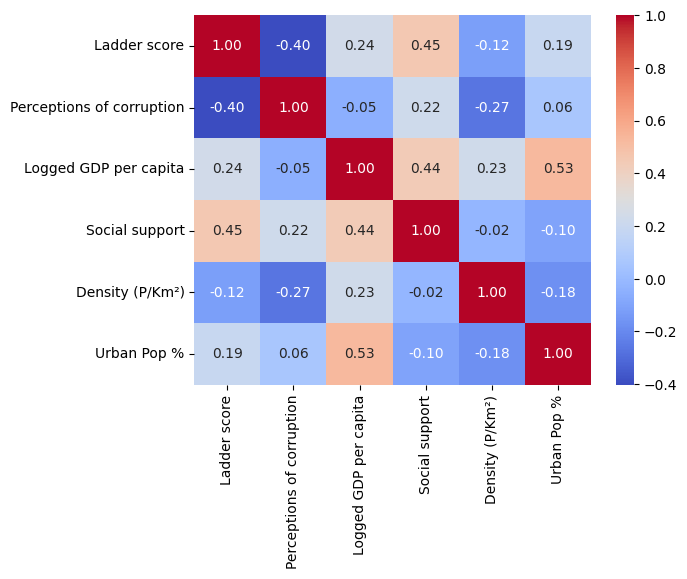

In [23]:
# @title Красивая матрица частных коэффицентов:
sns.heatmap(partial_corr , annot =True, fmt='.2f', cmap='coolwarm')
plt.show()

In [24]:
# @title Построение доверительных интервалов для коэффицентов корреляции:
from scipy.stats import t

def confidence_intervals(correlation_matrix: pd.DataFrame, alpha: float = 0.05) -> pd.DataFrame:
    n = correlation_matrix.shape[0]

    results = {
        'Variable1': [],
        'Variable2': [],
        'Lower': [],
        'Upper': [],
        'Correlation': []
    }
    for i in range(n):
        for j in range(i+1, n):
            r = correlation_matrix.iloc[i, j]

            if r == 1 or r == -1:
                lower_r = r
                upper_r = r
            else:
                z = 0.5 * np.log((1 + r) / (1 - r))

                se = 1 / np.sqrt(n - 3)

                critical_value = t.ppf(1 - alpha/2, n - 2)

                lower_z = z - critical_value * se
                upper_z = z + critical_value * se

                lower_r = (np.exp(2 * lower_z) - 1) / (np.exp(2 * lower_z) + 1)
                upper_r = (np.exp(2 * upper_z) - 1) / (np.exp(2 * upper_z) + 1)

            results['Variable1'].append(correlation_matrix.columns[i])
            results['Variable2'].append(correlation_matrix.columns[j])
            results['Lower'].append(lower_r)
            results['Upper'].append(upper_r)
            results['Correlation'].append(r)

    result_df = pd.DataFrame(results)

    return result_df



    # Вычисляем доверительные интервалы с помшщю приведенной выше фунции:
confidence_intervals_result = confidence_intervals(partial_corr)

print("Доверительные интервалы (при альфа = 0.05):")
print(confidence_intervals_result)

Доверительные интервалы (при альфа = 0.05):
                    Variable1                  Variable2     Lower     Upper  \
0                Ladder score  Perceptions of corruption -0.966070  0.826253   
1                Ladder score      Logged GDP per capita -0.876992  0.951118   
2                Ladder score             Social support -0.804930  0.970071   
3                Ladder score            Density (P/Km²) -0.938018  0.902340   
4                Ladder score                Urban Pop % -0.886750  0.946750   
5   Perceptions of corruption      Logged GDP per capita -0.929887  0.913522   
6   Perceptions of corruption             Social support -0.879880  0.949897   
7   Perceptions of corruption            Density (P/Km²) -0.954582  0.868010   
8   Perceptions of corruption                Urban Pop % -0.912896  0.930396   
9       Logged GDP per capita             Social support -0.811163  0.968994   
10      Logged GDP per capita            Density (P/Km²) -0.878074  0.950667

In [ ]:
# @title Проверка значимости частных коэффицентов корреляции:
def check_significance(correlation_matrix: pd.DataFrame, alpha: float = 0.05) -> pd.DataFrame:
    n = correlation_matrix.shape[0]

    results = {
        'Variable1': [],
        'Variable2': [],
        'Correlation': [],
        'p-value': [],
        'Significance': []
    }

    for i in range(n):
        for j in range(i+1, n):

            r = correlation_matrix.iloc[i, j]

            if r == 1 or r == -1:
                p_value = 0.0
            else:

                z = 0.5 * np.log((1 + r) / (1 - r))

                se = 1 / np.sqrt(n - 3)

                t_stat = z / se

                p_value = 2 * (1 - t.cdf(abs(t_stat), n - 2))

            significance = 'Значимый' if p_value < alpha else 'Не значимый'

            results['Variable1'].append(correlation_matrix.columns[i])
            results['Variable2'].append(correlation_matrix.columns[j])
            results['Correlation'].append(r)
            results['p-value'].append(p_value)
            results['Significance'].append(significance)

    result_df = pd.DataFrame(results)

    return result_df

significance_result = check_significance(partial_corr)

print("Результаты проверки значимости (при альфа = 0.05):")
print(significance_result)

Результаты проверки значимости (при альфа = 0.05):
                    Variable1                  Variable2  Correlation  \
0                Ladder score  Perceptions of corruption    -0.402620   
1                Ladder score      Logged GDP per capita     0.235868   
2                Ladder score             Social support     0.454631   
3                Ladder score            Density (P/Km²)    -0.117759   
4                Ladder score                Urban Pop %     0.193986   
5   Perceptions of corruption      Logged GDP per capita    -0.054522   
6   Perceptions of corruption             Social support     0.223887   
7   Perceptions of corruption            Density (P/Km²)    -0.271079   
8   Perceptions of corruption                Urban Pop %     0.058279   
9       Logged GDP per capita             Social support     0.440266   
10      Logged GDP per capita            Density (P/Km²)     0.231420   
11      Logged GDP per capita                Urban Pop %     0.525789   


**В данном случае все коэффиценты корреляции оказалиь статистически незначимы**, следовательно, выводов по найденым частным коэффицентам корреляции сделать нельзя.

---


*При этом выжно замметить что значимость болшенства (всех кроме двух) коэффицентов появляется только при уроне значимости более 0.5, что не имеет смысла так как вероятность ошибки будет более 50%, а следовательно неправельные выводы при оценке будут делатся чаще чем правельные.*

**Сравнение парных и частных коэффицентов корреляции**

---

Так как в нашем случае Все частные коэффйиценты корреляции оказались незначимы, то сравнение их с значимыми парными коэффицентами корреляции будет неправельным.

  *Вывод по парным коэффицентам корреляции можно посмотреть выше*

In [ ]:
# @title Расчет множественных коэфицентов корреляции по матрице парных коэфицентов корреляции с удаленными выбросами и Проверка их значимости:

import scipy.stats as stats

# Запишем матрицу парных коэффициентов корреляции с удаленными выбросаи полученную выше
correlation_matrix = np.array([
 [1.000000, -0.511880, 0.781061, 0.763237, 0.057719, 0.662041],
 [-0.511880, 1.000000, -0.350360, -0.269608, -0.021080, -0.305767],
 [0.781061, -0.350360, 1.000000, 0.782173, 0.087462, 0.768744],
 [0.763237, -0.269608, 0.782173, 1.000000, 0.034239, 0.588836],
 [0.057719, -0.021080, 0.087462, 0.034239, 1.000000, 0.009371],
 [0.662041, -0.305767, 0.768744, 0.588836, 0.009371, 1.000000]
])

columns = ['Ladder score', 'Perceptions of corruption', 'Logged GDP per capita', 'Social support', 'Density (P/Km²)', 'Urban Pop %']
df_correlation = pd.DataFrame(correlation_matrix, columns=columns, index=columns)

def calculate_multiple_correlation(correlation_matrix, target_column):

    target_correlations = correlation_matrix[target_column]

    target_correlations = target_correlations.drop(target_column)

    R = np.sqrt(1 - (1 - target_correlations**2).prod())

    return R

def calculate_p_value(R, n, k):
    t_stat = R * np.sqrt((n - k - 1) / (1 - R**2))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), n - k - 1))
    return p_value

print("Множественные коэффициенты корреляции и их значимость:")
n = 99
for column in columns:
    try:
        R = calculate_multiple_correlation(df_correlation, column)
        p_value = calculate_p_value(R, n, len(columns)-1)
        print(f"{column}:")
        print(f"  Множественный коэффициент корреляции: {R:.4f}")
        print(f"  P-value: {p_value:.4f}")
        if p_value < 0.05:
            print("  Значимость: Значимо на уровне 0.05")
        if p_value < 0.01:
            print("  Значимость: Значимо на уровне 0.01")
    except Exception as e:
        print(f"Ошибка при вычислении для {column}: {e}")

Множественные коэффициенты корреляции и их значимость:
Ladder score:
  Множественный коэффициент корреляции: 0.9658
  P-value: 0.0000
  Значимость: Значимо на уровне 0.05
  Значимость: Значимо на уровне 0.01
Perceptions of corruption:
  Множественный коэффициент корреляции: 0.6753
  P-value: 0.0000
  Значимость: Значимо на уровне 0.05
  Значимость: Значимо на уровне 0.01
Logged GDP per capita:
  Множественный коэффициент корреляции: 0.9727
  P-value: 0.0000
  Значимость: Значимо на уровне 0.05
  Значимость: Значимо на уровне 0.01
Social support:
  Множественный коэффициент корреляции: 0.9497
  P-value: 0.0000
  Значимость: Значимо на уровне 0.05
  Значимость: Значимо на уровне 0.01
Density (P/Km²):
  Множественный коэффициент корреляции: 0.1124
  P-value: 0.2780
Urban Pop %:
  Множественный коэффициент корреляции: 0.9295
  P-value: 0.0000
  Значимость: Значимо на уровне 0.05
  Значимость: Значимо на уровне 0.01


**Вывод мо множественным коэфицентам корреляции:** следующие множественные коэфиценты значимы на уровне значимости 1 процент: соц поддержка, , ln ввп на душу населения по ппс, восприятие корупции, процент городского населения и субъективное благополучие, в то время как множественный коэффицент корреляции плотности населения оказался незначимым, следовательно вывод по нему сделать нельзя.

В данной работе нас больше интересует множественный коэфицент значимости для целевой переменной: Субъективное благополучие.

Множественный коэффициент корреляции Ladder score составляет 0.9658, что указывает на очень сильную взаимосвязь между Ladder score и набором остальных исследуемых переменных. При этом значение p-value близко к 0, что подтверждает статистическую значимость этой связи на уровне 0.01 (один процент).

Это означает, что:

1. Существует тесная линейная зависимость между Ladder score и другими факторами.

2. Влияние всех остальных переменных (Perceptions of corruption, Logged GDP per capita, Social support, Density, Urban Pop) на Ladder score является существенным.

3. **Следовательно, полученная модель хорошо объясняет вариативность показателя Ladder score, что опять же свидетельствует о правильности выбор целевой переменной.**

## Регрессионный анализ. Линейная регрессионная модель.

Инициализируем целевую переменную и уберем название страны из датасета, эта переменная не оказывает влияние на субъективное благополучие.

In [25]:
key = rg_df['Ladder score']
rg_df = rg_df.drop(['Ladder score','country'], axis = 1)
rg_df

,Perceptions of corruption,Logged GDP per capita,Social support,Density (P/Km²),Urban Pop %
0,0.195445,10.639267,0.954330,18,0.86
1,0.168489,10.774001,0.955991,137,0.88
2,0.303728,10.979933,0.942847,219,0.74
3,0.711710,10.772559,0.974670,3,0.94
4,0.263218,11.087804,0.952487,15,0.83
...,...,...,...,...,...
137,0.891807,6.625160,0.319460,8,0.43
138,0.183541,7.600104,0.540835,525,0.18
139,0.810237,7.865712,0.763093,38,0.38
140,0.763417,7.425360,0.553707,18,0.25


Проверим количество нулевых значений, как видим таких нет.

In [26]:
rg_df.isna().sum()

,0
Perceptions of corruption,0
Logged GDP per capita,0
Social support,0
Density (P/Km²),0
Urban Pop %,0


Масштабируем данные для корректной работы линейный моделей.

In [27]:
from sklearn import preprocessing
normalizer = preprocessing.MinMaxScaler((1,2))
half_result = normalizer.fit_transform(rg_df)
df_for_reg = pd.DataFrame(half_result)
df_for_reg.head()

,0,1,2,3,4
0,1.103730,1.836344,1.968957,1.001915,1.877551
1,1.071089,1.863519,1.971492,1.016156,1.897959
2,1.234856,1.905054,1.951431,1.025969,1.755102
3,1.728899,1.863228,2.000000,1.000120,1.959184
4,1.185800,1.926810,1.966144,1.001556,1.846939


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.feature_selection import f_regression
import scipy.stats as stats
X_train, X_test, y_train, y_test = train_test_split(df_for_reg, key, test_size=0.2, random_state=42)

Первая модель (участвуют все признаки)

In [29]:
lm1 = LinearRegression()
lm1.fit(X_train, y_train)
y_pred1 = lm1.predict(X_test)
r2 = r2_score(y_test, y_pred1)
r2_adj = 1 - (1 - r2) * (142 - 1) / (142 - 5 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.8042926536447684


Вторая модель (без признака "urban pop%")



In [30]:
lm2 = LinearRegression()
lm2.fit(X_train[[0,1,2,3]], y_train)
y_pred2 = lm2.predict(X_test[[0,1,2,3]])
r2 = r2_score(y_test, y_pred2)
r2_adj = 1 - (1 - r2) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.8106297305342945


Третья модель (без признака "Perceptions of corruption")

In [31]:
lm3 = LinearRegression()
lm3.fit(X_train[[1,2,3,4]], y_train)
y_pred3 = lm3.predict(X_test[[1,2,3,4]])
r2 = r2_score(y_test, y_pred3)
r2_adj = 1 - (1 - r2) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.7684447646518768


Четвертая модель (без признака "Density (P/Km²)")

In [32]:
lm4 = LinearRegression()
lm4.fit(X_train[[0,1,2,4]], y_train)
y_pred4 = lm4.predict(X_test[[0,1,2,4]])
r2 = r2_score(y_test, y_pred4)
r2_adj = 1 - (1 - r2) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.8060069802210907


Пятая модель (без признака "Social support")

In [33]:
lm5 = LinearRegression()
lm5.fit(X_train[[0,1,3,4]], y_train)
y_pred5 = lm5.predict(X_test[[0,1,3,4]])
r2 = r2_score(y_test, y_pred5)
r2_adj = 1 - (1 - r2) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.6909601301028876


Шестая модель (без признака "Logged GDP per capita")

In [34]:
lm6 = LinearRegression()
lm6.fit(X_train[[0,2,3,4]], y_train)
y_pred6 = lm6.predict(X_test[[0,2,3,4]])
r2 = r2_score(y_test, y_pred6)
r2_adj = 1 - (1 - r2) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.7878561650067688


Согласно значению R2 adjusted вторая модель является наилучшей, так как она объясняет дисперсию случайной величины лучше всех (на 81%).

In [35]:
from sklearn.feature_selection import f_regression
F, p_value = f_regression(df_for_reg, key)
print(f"F-статистика: {F}, p-значение: {p_value}")

F-статистика: [ 33.70666584 223.53020591 205.39642197   0.84898138  79.75859045], p-значение: [4.11208952e-08 8.37403579e-31 3.05926087e-29 3.58425726e-01
 2.16632078e-15]


Переменная 3 статистически не значима. Значит ее можно исключить. Однако модель, которая ее исклю (вторая) имеет наибольшую объясняющую способность, согласно значению R2 adjusted, полученному ранее. Причиной такого результата скорее всего является то, что количество значений слишком мало, что ведет к нестабильности r2 adjusted. Поэтому мы будем использовать уравнение (4 модель), исключающее незначимый коэффициент, как самое лучшее.

In [36]:
X_with_const = sm.add_constant(df_for_reg[[0,1,2,4]])
model_sm = sm.OLS(key, X_with_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           Ladder score   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     97.30
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           4.78e-39
Time:                        15:21:11   Log-Likelihood:                -122.97
No. Observations:                 142   AIC:                             255.9
Df Residuals:                     137   BIC:                             270.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0597      0.704     -0.085      0.9

Данное уравнение статистически значимо, о чем говорить коэффициент F-statistic меньше 0.05

In [37]:
import scipy.stats as stats
residuals = y_test - y_pred1
shapiro_test = stats.shapiro(residuals)
print(f"Тест Шапиро-Уилка: {shapiro_test[1]:.4f}")

Тест Шапиро-Уилка: 0.6757


Нулевая гипотеза не отвергается на уровне значимости 5%. Значит остатки распределены нормально и модель адекватно описывает данные.

Визуализация остатков

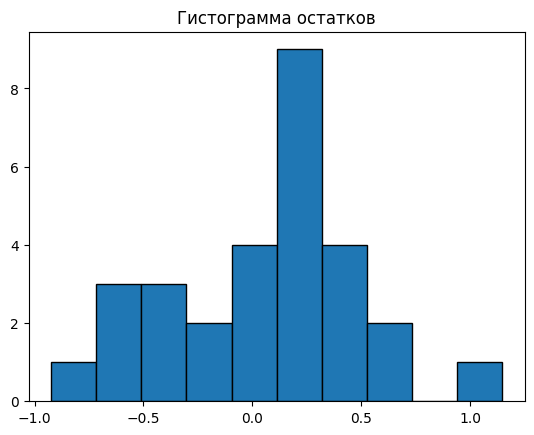

In [38]:
plt.hist(residuals, bins=10, edgecolor='black')
plt.title("Гистограмма остатков")
plt.show()

По графику (гистограмме остатков) нельзя сказать о принадлежности распределения остатков к нормальному.

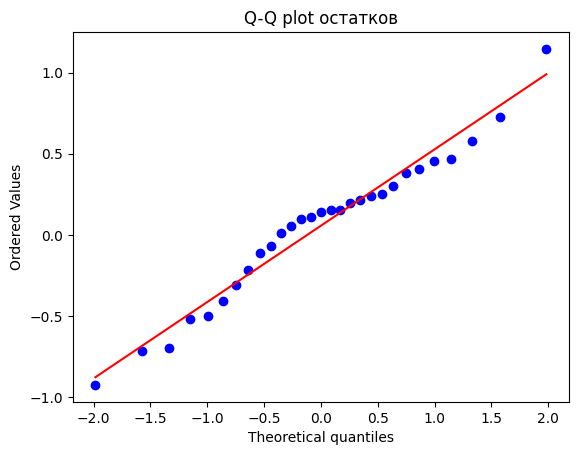

In [39]:
stats.probplot(residuals, plot=plt)
plt.title("Q-Q plot остатков")
plt.show()

Q-Q plot остков позволяет сказать, что распределение остатковпохоже на нормальное, хоть и с отклонениями.

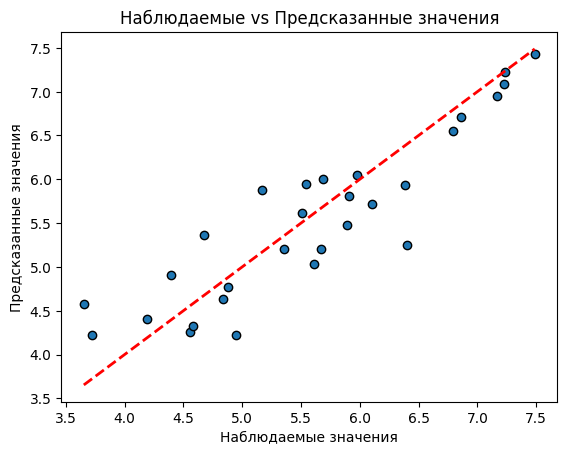

In [40]:
plt.scatter(y_test, y_pred1, edgecolor='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Наблюдаемые значения")
plt.ylabel("Предсказанные значения")
plt.title("Наблюдаемые vs Предсказанные значения")
plt.show()

По графику видно, что разброс достаточно равномерно распределен относительно оси.

In [41]:
print(f"Уравнение регрессии: y = {lm1.intercept_:.2f} + ({lm1.coef_[0]:.2f}) * x1 + {lm1.coef_[1]:.2f} * x2 + {lm1.coef_[2]:.2f} * x3 + {lm1.coef_[4]:.2f} * x5")

Уравнение регрессии: y = 0.79 + (-1.33) * x1 + 1.35 * x2 + 2.37 * x3 + 0.80 * x5


В нашем уравнении регрессии изменение первой переменной на 1 приведет к уменьшению значения всей модели на -1.33, второй переменной увеличит на 1.35, третьей увеличит на 2.37, пятой увеличит на 0.8. Константа равна 0.79.

## Регрессионный анализ. Нелинейная регрессионная модель.

In [43]:
X_train_log = np.log(X_train)
y_train_log = np.log(y_train)
X_test_log = np.log(X_test)
y_test_log = np.log(y_test)

Первая модель (все признаки учитываются)

In [44]:
nlm1 = LinearRegression()
nlm1.fit(X_train_log, y_train_log)
y_pred_log1 = nlm1.predict(X_test_log)
y_pred_1 = np.exp(y_pred_log1)
r2_1 = r2_score(y_test, y_pred_1)
r2_adj = 1 - (1 - r2_1) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.8100455369493698


Вторая модель (без признака "urban pop%")

In [46]:
nlm2 = LinearRegression()
nlm2.fit(X_train_log[[0,1,2,3]], y_train_log)
y_pred_log2 = nlm2.predict(X_test_log[[0,1,2,3]])
y_pred_2 = np.exp(y_pred_log2)
r2_2 = r2_score(y_test, y_pred_2)
r2_adj = 1 - (1 - r2_2) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.8080558560248433


Третья модель (без признака "Perceptions of corruption")

In [47]:
nlm3 = LinearRegression()
nlm3.fit(X_train_log[[1,2,3,4]], y_train_log)
y_pred_log3 = nlm3.predict(X_test_log[[1,2,3,4]])
y_pred_3 = np.exp(y_pred_log3)
r2_3 = r2_score(y_test, y_pred_3)
r2_adj = 1 - (1 - r2_3) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.7652112370013595


Четвертая модель (без признака "Density (P/Km²)")

In [48]:
nlm4 = LinearRegression()
nlm4.fit(X_train_log[[0,1,2,4]], y_train_log)
y_pred_log4 = nlm4.predict(X_test_log[[0,1,2,4]])
y_pred_4 = np.exp(y_pred_log4)
r2_4 = r2_score(y_test, y_pred_4)
r2_adj = 1 - (1 - r2_4) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.8102026037453562


Пятая модель (без признака "Social support")

In [49]:
nlm5 = LinearRegression()
nlm5.fit(X_train_log[[0,1,3,4]], y_train_log)
y_pred_log5 = nlm5.predict(X_test_log[[0,1,3,4]])
y_pred_5 = np.exp(y_pred_log5)
r2_5 = r2_score(y_test, y_pred_5)
r2_adj = 1 - (1 - r2_5) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.699874016975994



Шестая модель (без признака "Logged GDP per capita")

In [50]:
nlm6 = LinearRegression()
nlm6.fit(X_train_log[[0,2,3,4]], y_train_log)
y_pred_log6 = nlm6.predict(X_test_log[[0,2,3,4]])
y_pred_6 = np.exp(y_pred_log6)
r2_6 = r2_score(y_test, y_pred_6)
r2_adj = 1 - (1 - r2_6) * (142 - 1) / (142 - 4 - 1)
print(f'Коэффициент детерминации: {r2_adj}')

Коэффициент детерминации: 0.7894653064847699


In [ ]:
X_train_log_const = sm.add_constant(X_train_log)
model_sm = sm.OLS(y_train_log, X_train_log_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           Ladder score   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     45.50
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           5.69e-25
Time:                        21:39:43   Log-Likelihood:                 72.539
No. Observations:                 113   AIC:                            -133.1
Df Residuals:                     107   BIC:                            -116.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1398      0.088     13.001      0.0

Переменная 3 незначима (0.893>0,05) на уровне значимости 5%, исключим ее и получим модель с наибольшим R2 adjusted (модель без этой переменной объясняет дисперсию на 81%, что больше всех остальных моделей). Будем считать ее оптимальной.

In [ ]:
X_train_log_const = sm.add_constant(X_train_log[[0,1,2,4]])
model_sm = sm.OLS(y_train_log, X_train_log_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           Ladder score   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     57.39
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           7.07e-26
Time:                        21:39:43   Log-Likelihood:                 72.529
No. Observations:                 113   AIC:                            -135.1
Df Residuals:                     108   BIC:                            -121.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1359      0.082     13.791      0.0

 Prob (F-statistic):           7.07e-26 что сильно меньше 0.05, значит уравнение регресси значимо.

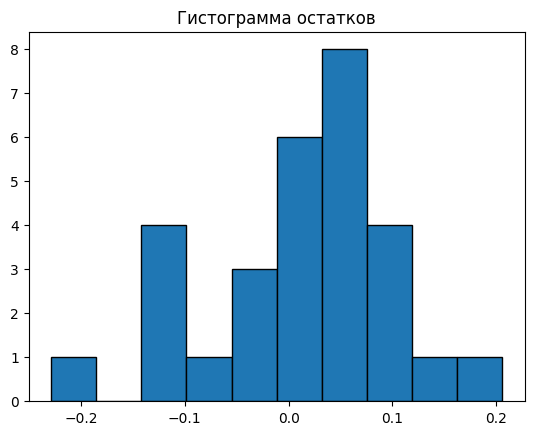

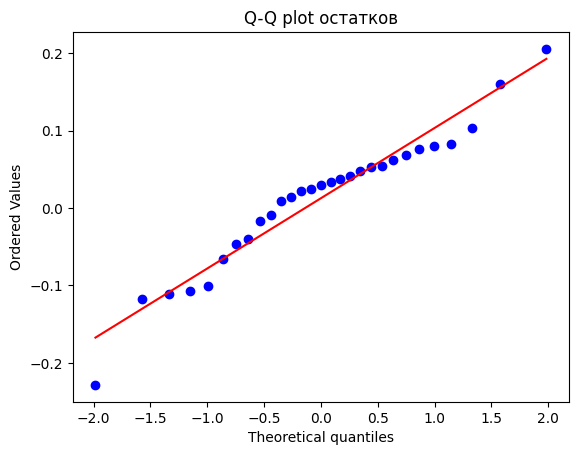

Тест Шапиро-Уилка: p-значение = 0.3063


In [ ]:
residuals = y_test_log - model_sm.predict(sm.add_constant(X_test_log[[0,1,2,4]]))
plt.hist(residuals, bins=10, edgecolor='black')
plt.title("Гистограмма остатков")
plt.show()
stats.probplot(residuals, plot=plt)
plt.title("Q-Q plot остатков")
plt.show()
shapiro_test = stats.shapiro(residuals)
print(f"Тест Шапиро-Уилка: p-значение = {shapiro_test[1]:.4f}")

Тест Шапиро-Уилка говорит о том, что гипотеза о нормальном распределении остатков не отвергается на уровне значимости 5%. По гистограмме распределения остатков нельзя сказать о то, что они являются нормально распределенными, однако гарфик Q-Q plot остатков похож на график для нормального распределения, что подтверждает рещультат теста Шапиро-Уилка.

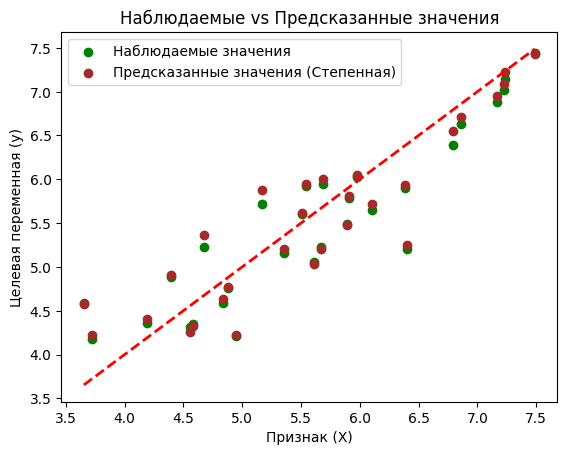

In [ ]:
plt.scatter(y_test, y_pred_1, color='green', label='Наблюдаемые значения')
plt.scatter(y_test, y_pred1, color='brown', label='Предсказанные значения (Степенная)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Признак (X)")
plt.ylabel("Целевая переменная (y)")
plt.legend()
plt.title("Наблюдаемые vs Предсказанные значения")
plt.show()

По графику видно, что разброс достаточно равномерно распределен относительно оси.

In [ ]:
a = np.exp(model_sm.params[0])
b1, b2, b3, b5 = model_sm.params[1:]
print(f"Уравнение степенной регрессии: y = {a:.2f} * x1^{b1:.2f} * x2^{b2:.2f} * x3^{b3:.2f} * x5^{b5:.2f}")

Уравнение степенной регрессии: y = 0.74 * x1^-0.30 * x2^0.33 * x3^0.80 * x5^0.26


В нашем уравнении регрессии изменение первой переменной на 1 приведет к увеличению значения всей модели на 0.74, второй переменной уменьшит на 0.3 , третьей увеличит на 0.8, пятой увеличит на 026. Константа равна 0.74.

## Регрессионный анализ. Итог.

Линейная модель имеет более высокий *Adjusted R^2* (**0.732** против **0.668**), что указывает на лучшую способность объяснять вариацию зависимой переменной.

Кроме того, её *F-статистика* (**97.30** против **57.39**) говорит о большей значимости модели в целом.

Таким образом, линейная регрессия является лучшим выбором.
